# Problem 1

## Importing libraries

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Comment to get non-deterministic results
np.random.seed(2)

## Neural Network Implementation

In [4]:
#Several functions in this class implementation are inspired from the NN implemented in cours IFT6093

class NN(object):
    
    '''
    Arguments:
        input_dim: The input dimension
        output_dim: The output dimension
        hidden_dims: (h1 dimension, h2 dimension)
        n_hidden: number of hidden layers
        initialization: type of weigth initialization (zeros, normal or glorot)
    
    '''
    
    def __init__(self, input_dim, output_dim,hidden_dims=(1024,2048),n_hidden=2, initialization='zeros', mode=',train',
                 datapath=None,model_path=None):
        
        self.indim = input_dim
        self.hd1 = hidden_dims[0] 
        self.hd2 = hidden_dims[1]
        self.n_hidden = n_hidden
        self.outd = output_dim
        self.W1 = np.zeros(shape=(hidden_dims[0], input_dim))
        self.b1 = np.zeros(hidden_dims[0])
        self.W2 = np.zeros(shape=(hidden_dims[1], hidden_dims[0]))
        self.b2 = np.zeros(hidden_dims[1])
        self.W3 = np.zeros(shape=(output_dim, hidden_dims[1]))
        self.b3 = np.zeros(output_dim)
        
        
        if initialization=='normal':
            self.initialize_weights_normal()
            
        if initialization=='glorot':
            self.initialize_weights_glorot()
           
        self.parameters = [self.W3, self.b3, self.W2, self.b2, self.W1, self.b1]
        
        
    def initialize_weights_normal(self):
        
        self.W1 = np.random.normal(size=(self.hd1, self.indim))
        self.W2 = np.random.normal(size=(self.hd2, self.hd1))
        self.W3 = np.random.normal(size=(self.outd, self.hd2))
        return self
    
    
    
    def initialize_weights_glorot(self):
        
        dl1 = np.sqrt(6/(self.indim + self.hd1))
        dl2 = np.sqrt(6/(self.hd1 + self.hd2))
        dl3 = np.sqrt(6/(self.hd2 + self.outd))
        self.W1 = np.random.uniform(low=(-dl1), high=dl1, size=(self.hd1, self.indim))
        self.W2 = np.random.uniform(low=(-dl2), high=dl2, size=(self.hd2, self.hd1))
        self.W3 = np.random.uniform(low=(-dl3), high=dl3, size=(self.outd, self.hd2))
        return self
        
        
    #Method from NN implemented in cours IFT6093
    def activation (self,input):
        
        return (input > 0) * input  
    
    #line 85

    def forward(self,x):
                
        a1 = np.dot (self.W1, x) + self.b1 
        h1 = self.activation (a1)
        a2 = np.dot (self.W2, h1) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (self.W3, h2) + self.b3
        os = self.softmax (oa, axis=0)
        
        return a1, h1, a2, h2, oa, os
    
    

    #Loss ans softmax methods from NN implemented in cours IFT6093
    def loss (self, y, os):
        return (y * (-np.log(os))).sum()
    

    def softmax (self,x,axis=1):
        shiftx = x - np.max (x, axis=axis, keepdims=True)
        exps = np.exp (shiftx)
        y = exps / exps.sum (axis=axis, keepdims=True)
        return y


    def backward(self, x, y, a1, h1, a2, h2, oa, os, weight_decay=0, cache=None):
        
        grad_oa = os - y
        grad_W3 = np.outer (grad_oa, h2) + weight_decay * self.W3
        grad_b3 = grad_oa
        grad_h2 = np.dot (self.W3.T, grad_oa)
        grad_a2 = (a2 > 0) * grad_h2
        grad_W2 = np.outer (grad_a2, h1) + weight_decay * self.W2
        grad_b2 = grad_a2
        grad_h1 = np.dot (self.W2.T, grad_a2)
        grad_a1 = (a1 > 0) * grad_h1
        grad_W1 = np.outer (grad_a1, x) + weight_decay * self.W1
        grad_b1 = grad_a1
        grads=[grad_W3, grad_b3, grad_W2, grad_b2, grad_W1, grad_b1]
   
        return grads



    def update(self, grads, learning_rate):
        for p, grad in zip(self.parameters, grads):
            p -= learning_rate * grad
        
    #line 201   

    def train_SGD(self, x, y_onehot, n, learning_rate=1e-1, weight_decay=0):
                
        y = y_onehot
        losses = 0
        if (n==1):
            a1, h1, a2, h2, oa, os = self.forward(x)
            grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
            self.update(grads, learning_rate)
            loss = self.loss(y, os)
            losses += loss  
            average_loss = losses / n
        else:    
            for j in range(x.shape[0]):
                a1, h1, a2, h2, oa, os = self.forward(x[j])
                grads = self.backward(x[j], y[j], a1, h1, a2, h2, oa, os)
                self.update(grads, learning_rate)
                loss = self.loss(y[j], os)
                losses += loss     
            average_loss = losses / n
                
        return average_loss
    
    
    def prediction_SGD (self, x):
        predictions = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            predictions[i] = os.argmax()
                
        return predictions
                
    
    def accuracy_SGD (self, prediction, y):
        accuracies=0
        for i in range (y.shape[0]):
            accuracies+=(prediction[i]==y[i])
            
        return accuracies / y.shape[0]
    
    
    def test_SGD(self, x, y_onehot, y):
        pred=np.zeros(y.shape[0])
        avg_loss=0
        for i in range (x.shape[0]):
            _, _, _, _, _, os = self.forward(x[i])
            loss=self.loss (y_onehot[i], os)
            avg_loss+=loss
            pred[i]=os.argmax()
            
        accuracy=self.accuracy_SGD(pred, y)    
        return avg_loss / x.shape[0] , accuracy
    
   
    def forward_mbatch(self, x):
                
        a1 = np.dot ( x, self.W1.T) + self.b1
        h1 = self.activation (a1)
        a2 = np.dot (h1, self.W2.T) + self.b2
        h2 = self.activation (a2)
        oa = np.dot (h2, self.W3.T) + self.b3
        os = self.softmax (oa, axis=1)
                
        return a1, h1, a2, h2, oa, os
    
    #line 303
        
    def backward_mbatch(self, x, y, a1, h1, a2, h2, oa, os, batch_n, weight_decay=0):
                
        batch_n = x.shape[0]
        bgrad_oa = os - y
        bgrad_W3 = np.dot (bgrad_oa.T, h2) / batch_n  + weight_decay * self.W3
        bgrad_b3 = bgrad_oa.mean(axis=0)
        bgrad_h2 = np.dot (bgrad_oa, self.W3)
        bgrad_a2 = (a2 > 0) * bgrad_h2
        bgrad_W2 = np.dot (bgrad_a2.T, h1) / batch_n  + weight_decay * self.W2
        bgrad_b2 = bgrad_a2.mean(axis=0)
        bgrad_h1 = np.dot (bgrad_a2, self.W2)
        bgrad_a1 = (a1 > 0) * bgrad_h1
        bgrad_W1 = np.dot (bgrad_a1.T, x) / batch_n  + weight_decay * self.W1
        bgrad_b1 = bgrad_a1.mean(axis=0)
        bgrads=[bgrad_W3, bgrad_b3, bgrad_W2, bgrad_b2, bgrad_W1, bgrad_b1]
   
        return bgrads

    #line 360

    #Method taken fron homwork 3 in cours IFT6093
    def loss_mbatch(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)     
        
    
    #training with minibatch gradient decent
    def train_mbatch(self, x, y_onehot, mb_size=100, learning_rate=1e-1, weight_decay=0):
                
        average_loss=0
        for i in range (0, x.shape[0], mb_size):
            xi = x[i:(i+mb_size)]
            yi = y_onehot[i:(i+mb_size)]
        
            #losses = 0
            a1, h1, a2, h2, oa, os = self.forward_mbatch(xi)
            grads = self.backward_mbatch (xi, yi,a1, h1, a2, h2,oa, os, mb_size)
            self.update(grads, learning_rate)
            average_loss = self.loss_mbatch(os, yi) 
                          
        return average_loss
    
    
    #line 385
    
    def prediction_mbatch (self, x):
        _, _, _, _, _, os = self.forward_mbatch(x)
        return os.argmax(axis=1)
    

    def accuracy_mbatch (self, prediction, y):
        accuracy = np.zeros(y.shape[0])
        accuracy = prediction == y
        return accuracy.mean(axis=0)
    

    def test_mbatch(self, x, y_onehot, y):
        _, _, _, _, _, os = self.forward_mbatch(x)
        loss = self.loss_mbatch (os, y_onehot)
        accuracy=self.accuracy_mbatch (os.argmax(axis=1), y)
        return loss, accuracy
    
    
    def finite_difference():
        
        pass


## Function onehot

In [5]:
#function taken from IFT6093 cours
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

## Data loader

In [6]:
#part of code inspired from : https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python

import gzip
def dataloader_X(filename, rows, cols, image_size = 0):
    f = gzip.open(filename,'r')
    image_size = image_size
    num_images = rows

    f.read(8)
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
    c=data.reshape(rows, image_size, image_size)
    print(c.shape)
    c=data.reshape(rows, (image_size*image_size) )
    print(c.shape)  
        
    return c

def dataloader_y(filename, rows):
    f = gzip.open(filename,'r')

    f.read(8)
    buf = f.read()
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
    print(labels.shape)  
        
    return labels

* Charging data

In [7]:
from random import shuffle

X_train = dataloader_X('train-images-idx3-ubyte.gz', 60000, 284, image_size = 28 )
X_test = dataloader_X('t10k-images-idx3-ubyte.gz', 10000, 284, image_size = 28 )
y_train = dataloader_y('train-labels-idx1-ubyte.gz', 60000)
y_test =  dataloader_y('t10k-labels-idx1-ubyte.gz', 10000)


# Data normalization
X_train= X_train / 255
X_test = X_test / 255


# Data randomization
indices = list(range(len(X_train)))
shuffle(indices)

#Split train set in training and validation set
X_valid, y_valid = X_train[indices[55000:]], y_train[indices[55000:]]
X_train, y_train = X_train[indices[:55000]], y_train[indices[:55000]]

digit_y_train_onehot= onehot (y_train, 10)
digit_y_valid_onehot= onehot (y_valid, 10)
digit_y_test_onehot= onehot (y_test, 10)


print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_valid shape = ', X_valid.shape)
print('y_valid shape = ', y_valid.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

(60000, 28, 28)
(60000, 784)
(10000, 28, 28)
(10000, 784)
(60000,)
(10000,)
X_train shape =  (55000, 784)
y_train shape =  (55000,)
X_valid shape =  (5000, 784)
y_valid shape =  (5000,)
X_test shape =  (10000, 784)
y_test shape =  (10000,)


## Initialization

Weigths initialization, data from dataloader


C:\Miniconda3\lib\site-packages\ipykernel\__main__.py:205: RuntimeWarning: divide by zero encountered in log
C:\Miniconda3\lib\site-packages\ipykernel\__main__.py:205: RuntimeWarning: invalid value encountered in multiply


Time with minibatch gradient decent implementation: 849.515589 seconds



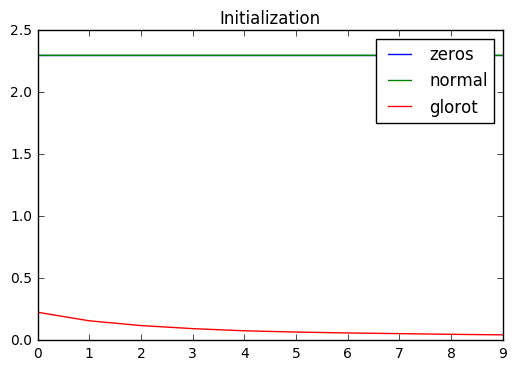

In [7]:
#1. Weigths initialization data from dataloader

print('Weigths initialization, data from dataloader')

# Set timer
import time
start_time = time.time()

#training 10 epochs for each initialization type
epochs=10

zeros_losses=[]
normal_losses=[]
glorot_losses=[]
weigths=['zeros', 'normal', 'glorot']

for i, init in enumerate(weigths, 0):
    
    NN_digits= NN(784, 10, hidden_dims=(500,300), initialization=init)

    for epoch in range (epochs): 
    
        loss=NN_digits.train_mbatch(X_train, digit_y_train_onehot, mb_size=100)
        if (init=='zeros'):
            zeros_losses.append(loss)
        if (init == 'normal'):
            normal_losses.append(loss)
        if (init == 'glorot'):
            glorot_losses.append(loss)
            
time_mb = time.time() - start_time
print('Time with minibatch gradient decent implementation: %f seconds\n' % time_mb)


fig = plt.figure()
plt.plot(range(epochs),  zeros_losses, label='zeros')
plt.plot(range(epochs), normal_losses, label='normal')
plt.plot(range(epochs), glorot_losses, label='glorot')
plt.title("Initialization")

plt.legend()
plt.show()



## Parameter search

Functions declaration:

In [8]:
# Train the model using different hyperparameters, like mini-batch size, learning rate and epochs number
# x_ds is the dataset to train, y_ds is the target dataset.


# function to test different hyperparameters
# x_ds and y_ds must be the training set



def hyperparameter_search(model, x_t, y_t, y_t_o, x_v, y_v, y_v_o, epochs, minibatch, learningrate,
                          verbose=False):
    
    # NN model
    # NN_mbatch_1 = NN(784, 10, hidden_dims=(500,300), initialization='glorot')
    
    # Model training 
    losses_train, accs_train = [], []
    losses_valid, accs_valid = [], []
    #losses_test, preds_test = [], []
        
        
    for epoch in range (epochs): 
        
        # Always train in training set
                
        loss_mbatch_1 = model.train_mbatch(x_t, y_t_o, mb_size=minibatch,
                                                 learning_rate=learningrate)
        
        if verbose:
            print('epoch ', epoch, ' loss ', loss_mbatch_1)
            
            
        #Test in validation set to adjust Hyperparameters        
        loss_train, acc_train = model.test_mbatch(x_t, y_t_o, y_t)
        loss_valid, acc_valid = model.test_mbatch(x_v, y_v_o, y_v)        
        
        
        losses_train.append(loss_train) 
        accs_train.append(acc_train)
        losses_valid.append(loss_valid)
        accs_valid.append(acc_valid)
        
    
    #Test in validation set to adjust Hyperparameters
    
    #loss,accuracy = NN_mbatch_1.test_mbatch(x_ds,y,y_ds)
    print('epoch ', epoch, ' loss ', loss_mbatch_1)
    
    #Only at the end, test in test set 
    
    return losses_train, acc_train, losses_valid, acc_valid, model

In [9]:
# testing for different h1 size



for i, h1 in enumerate([500, 600, 800, 1000]):
    print(h1)
    
    NN_mbatch_1 = NN(784, 10, hidden_dims=(h1,300), initialization='glorot')
    
    losses_train, preds_train, losses_valid, preds_valid, NN_mbatch_1 = hyperparameter_search(
        NN_mbatch_1, X_train, y_train, digit_y_train_onehot, X_valid, y_valid, digit_y_valid_onehot, 
        10, 100, 1e-1, verbose=True)
    
 


500
epoch  0  loss  0.14581453092038102
epoch  1  loss  0.08653862662573525
epoch  2  loss  0.05584058661953494
epoch  3  loss  0.03977169112867238
epoch  4  loss  0.029163141280530488
epoch  5  loss  0.022867748552135483
epoch  6  loss  0.018304303721175932
epoch  7  loss  0.015072465969688517
epoch  8  loss  0.012517681531048827
epoch  9  loss  0.01040159495356941
epoch  9  loss  0.01040159495356941
600
epoch  0  loss  0.14400304299939368
epoch  1  loss  0.08327159855685291
epoch  2  loss  0.05222551711269508
epoch  3  loss  0.036253690260122685
epoch  4  loss  0.027346689746163687
epoch  5  loss  0.022180972603945564
epoch  6  loss  0.018563148203478017
epoch  7  loss  0.015449373732080315
epoch  8  loss  0.013088962738955691
epoch  9  loss  0.010971804726865384
epoch  9  loss  0.010971804726865384
800
epoch  0  loss  0.1239439884161044
epoch  1  loss  0.06904779049486472
epoch  2  loss  0.04559550672097166
epoch  3  loss  0.03323956798016456
epoch  4  loss  0.026215202329884675
epo

## Finite difference

In [54]:
#Approximation of the gradient of the loos at the end of training, with respect to W3 
# (the second layer weigths) with to the first p = min(10;m) elements of W3.


#function to calculate the finite difference for  

def loop_finite_diff(self, x, y, epsilon=1e-5):
        a1, h1, a2, h2, oa, os = self.forward(x)
        grads = self.backward(x, y, a1, h1, a2, h2, oa, os)
        loss = self.loss(y, os)
        
        grads_finite_diff = []
        
        for p in self.parameters[0]:
            grad_fdiff = np.zeros(shape=p.shape)
            for i, v in np.ndenumerate(p):
                p[i] += epsilon
                _, _, _, _, _, os = self.forward(x)
                loss_diff = self.loss(os, y)
                grad_fdiff[index] = (loss_diff - loss) / epsilon
                p[index] -= epsilon
            grads_finite_diff.append(grad_fdiff)
        return gradients_finite_diff

In [63]:
#1. epsilon = 1 / N

#Use at least 5 values of N from the set {k10**i : i E {0; : : : ; 5g} k E {1, 5}}
epsilon=[]
N = []
for exp in range (1, 6, 2):
    a= 10**exp
    N.append(a)
for exp in range (1, 5, 2):
    b= 5*10**exp
    N.append(b)
for i in range (5):
    epsilon.append(1/N[i])

print (N)
print (epsilon)




[10, 1000, 100000, 50, 5000]
[0.1, 0.001, 1e-05, 0.02, 0.0002]
